<a href="https://colab.research.google.com/github/holezekki99/JODA2022/blob/harjoitusty%C3%B6/Goalie_salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goalie salary predictor

In this workbook we're trying to make a model that could predict what would be the fair salary for NHL goalie based on his performance. We are looking if and how strong link there is between goalie stats and salary.

The statistical data for goelies performance is downloaded from Moneypuck.com website. The earnings are webscraped from spotrac.com.

### Aquiring data

We need goalie game statistics first. Separate files for every season. We'll be looking 3 year history:

In [2]:
# Create data-directory
!mkdir ./data

In [3]:
years = ['2020', '2021']

In [4]:
# Get the data for seasons starting 2019-2021 and write them to files
import pandas as pd
import requests

for i in years:
  year = str(i)
  url = ('https://moneypuck.com/moneypuck/playerData/seasonSummary/' + year + '/regular/goalies.csv')
  page = requests.get(url)
  r = requests.get(url)
  fname = ('./data/stat' + year + '.csv')
  open(fname, 'wb').write(r.content)


A data dictionary which explains all of the columns in the datasets can be downloaded [HERE](https://peter-tanner.com/moneypuck/downloads/MoneyPuckDataDictionaryForPlayers.csv)

Next step is to webscrape salary (caphit) information for seasons 2020-21 and 2021-22 and write the result into salaries.csv file.

We use beautifulsoup library for scraping:

In [5]:
from bs4 import BeautifulSoup

# Defining of the dataframe, we collect only name, year and caphit
df = pd.DataFrame(columns=['name', 'season', 'caphit'])

for i in years:
  year = str(i)
  url = ('https://www.spotrac.com/nhl/positional/' + year + '/goaltender/active-cap/')
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  table = soup.find_all('table')[1]
  #table = soup.find_all('table')[1] # Table 1 is the list of goalies
  # Collecting Ddata
  for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    if(columns != []):
      name = columns[2].text.strip()
      # Use only familyname since the first names might be spelled differently.
      #name = name.split()[-1]
      
      # We later found out that there are four names wrongly spelled in salary dataset. Let's correct those:
      # Correct Vasilevskiy familyname
      if name == 'Andrei Vasilevski':
        name = 'Andrei Vasilevskiy'
      # Correct Grubauer's firstname
      if name == 'Phillip Grubauer':
        name = 'Philipp Grubauer'
      # Correct Talbot's firstname
      if name == 'Cameron Talbot':
        name = 'Cam Talbot'
      # Correct Georgievs's firstname
      if name == 'Alexander Georgiev':
        name = 'Alexandar Georgiev'

        
      year = year
      caphit = columns[3].text.strip()
      df = df.append({'name': name,  'season': year, 'caphit': caphit}, ignore_index=True)


In [6]:
df

,name,season,caphit
0,Carey Price,2020,"$10,500,000"
1,Sergei Bobrovsky,2020,"$10,000,000"
2,Andrei Vasilevskiy,2020,"$9,500,000"
3,Tuukka Rask,2020,"$7,000,000"
4,Marc-Andre Fleury,2020,"$7,000,000"
...,...,...,...
156,Erik Källgren,2021,"$750,000"
157,Connor Ingram,2021,"$733,333"
158,Kaapo Kahkonen,2021,"$725,000"
159,Dustin Tokarski,2021,"$725,000"


In [7]:
# Write the salaries to a salary.csv
df.to_csv('./data/salaries.csv', index=False)  

### Data cleaning and preprosessing
Next step is to merge the stats-datafiles into a single dataframe, investigate what we have on statistics and clean the data if needed:

We start by merging all stat-files into stat_df dataframe:

In [8]:
# Make one dataframe out of multiple statistical files (https://www.geeksforgeeks.org/how-to-merge-multiple-csv-files-into-a-single-pandas-dataframe/)

# importing libraries
import glob
import os
  
# merging the files
stat_files = os.path.join("./data", "stat*.csv")
  
# A list of all joined files is returned
stats_list = glob.glob(stat_files)
  
# Finally, the files are joined
stat_df = pd.concat(map(pd.read_csv, stats_list), ignore_index=True)

# Use only family name. Datasources seem to have differencies in firstnames. (https://pandas.pydata.org/docs/getting_started/intro_tutorials/10_text_data.html)
#stat_df['name'] = stat_df['name'].str.split().str.get(1)
stat_df.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
0,8470147,2020,Curtis McElhinney,T.B,G,other,12,1310.0,2.74,1.0,...,2.0,0.81,1.10,0.83,0.0,1.0,0.0,8.0,0.0,0.0
1,8470147,2020,Curtis McElhinney,T.B,G,all,12,43159.0,26.49,37.0,...,20.0,8.04,11.12,7.33,12.0,17.0,8.0,114.0,2.0,1.0
2,8470147,2020,Curtis McElhinney,T.B,G,5on5,12,33877.0,16.25,29.0,...,10.0,5.87,7.75,2.63,10.0,15.0,4.0,85.0,2.0,1.0
3,8470147,2020,Curtis McElhinney,T.B,G,4on5,12,3543.0,6.25,6.0,...,8.0,1.11,1.27,3.87,2.0,0.0,4.0,19.0,0.0,0.0
4,8470147,2020,Curtis McElhinney,T.B,G,5on4,12,4429.0,1.25,1.0,...,0.0,0.25,1.00,0.00,0.0,1.0,0.0,2.0,0.0,0.0


In [9]:
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   1085 non-null   int64  
 1   season                     1085 non-null   int64  
 2   name                       1085 non-null   object 
 3   team                       1085 non-null   object 
 4   position                   1085 non-null   object 
 5   situation                  1085 non-null   object 
 6   games_played               1085 non-null   int64  
 7   icetime                    1085 non-null   float64
 8   xGoals                     1085 non-null   float64
 9   goals                      1085 non-null   float64
 10  unblocked_shot_attempts    1085 non-null   float64
 11  xRebounds                  1085 non-null   float64
 12  rebounds                   1085 non-null   float64
 13  xFreeze                    1085 non-null   float

We have multiple rows for each season per goalie. There is also a row for all different game situations (5vs.5, 5vs.4 etc). We're not interested to the difference in different situations, but keep only the "all" rows: 

In [10]:
# remove rows using the drop() function
stat_df.drop(stat_df.index[stat_df['situation'] != 'all'], inplace=True)
stat_df.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
1,8470147,2020,Curtis McElhinney,T.B,G,all,12,43159.0,26.49,37.0,...,20.0,8.04,11.12,7.33,12.0,17.0,8.0,114.0,2.0,1.0
6,8473503,2020,James Reimer,CAR,G,all,22,79866.0,52.62,59.0,...,38.0,19.04,21.47,12.11,16.0,30.0,13.0,245.0,0.0,0.0
11,8477424,2020,Juuse Saros,NSH,G,all,36,123082.0,91.15,78.0,...,77.0,31.99,31.31,27.85,24.0,29.0,25.0,441.0,2.0,1.0
16,8476945,2020,Connor Hellebuyck,WPG,G,all,45,156169.0,131.25,112.0,...,132.0,38.44,52.86,39.96,28.0,50.0,34.0,598.0,0.0,0.0
21,8481001,2020,Veini Vehvilainen,CBJ,G,all,1,640.0,0.13,1.0,...,0.0,0.13,0.00,0.00,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 1 to 1081
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   217 non-null    int64  
 1   season                     217 non-null    int64  
 2   name                       217 non-null    object 
 3   team                       217 non-null    object 
 4   position                   217 non-null    object 
 5   situation                  217 non-null    object 
 6   games_played               217 non-null    int64  
 7   icetime                    217 non-null    float64
 8   xGoals                     217 non-null    float64
 9   goals                      217 non-null    float64
 10  unblocked_shot_attempts    217 non-null    float64
 11  xRebounds                  217 non-null    float64
 12  rebounds                   217 non-null    float64
 13  xFreeze                    217 non-null    float6

The datatypes in the statististics dataframe are ok. The dataset is good quality, no need for further cleaning. For the time being we'll keep all columns but *penalityMinutes* and *penalties*.

In [12]:
stat_df.drop(['penalityMinutes', 'penalties'], axis=1, inplace=True)

The next step is to load salary.csv into sal_df:

In [13]:
# Load salaries.csv into a dataframe

sal_df = pd.read_csv('./data/salaries.csv')
sal_df.head()

,name,season,caphit
0,Carey Price,2020,"$10,500,000"
1,Sergei Bobrovsky,2020,"$10,000,000"
2,Andrei Vasilevskiy,2020,"$9,500,000"
3,Tuukka Rask,2020,"$7,000,000"
4,Marc-Andre Fleury,2020,"$7,000,000"


In [14]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    161 non-null    object
 1   season  161 non-null    int64 
 2   caphit  161 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.9+ KB


In [15]:
# Convert year into numeric value:
sal_df['season'] = sal_df['season'].astype(int)

# Convert caphit into numeric value.
sal_df['caphit'] = sal_df['caphit'].replace("[$,]", "", regex=True).astype(int)

In [16]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    161 non-null    object
 1   season  161 non-null    int64 
 2   caphit  161 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.9+ KB


Now we need to merge the dataframes. Insert into stat_df a new column with salary information ("caphit").

In [17]:
stat_df.shape


(217, 34)

In [18]:
sal_df.shape

(161, 3)

Use merge method with outer left join. We keep all the values in stats dataframe and include the caphit (salary) from salary dataframe.

In [19]:
merged_df = pd.merge(stat_df, sal_df, how="left", on=["season", "name"])
merged_df

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
0,8470147,2020,Curtis McElhinney,T.B,G,all,12,43159.0,26.49,37.0,...,88.0,20.0,8.04,11.12,7.33,12.0,17.0,8.0,114.0,1300000.0
1,8473503,2020,James Reimer,CAR,G,all,22,79866.0,52.62,59.0,...,174.0,38.0,19.04,21.47,12.11,16.0,30.0,13.0,245.0,3400000.0
2,8477424,2020,Juuse Saros,NSH,G,all,36,123082.0,91.15,78.0,...,255.0,77.0,31.99,31.31,27.85,24.0,29.0,25.0,441.0,1500000.0
3,8476945,2020,Connor Hellebuyck,WPG,G,all,45,156169.0,131.25,112.0,...,435.0,132.0,38.44,52.86,39.96,28.0,50.0,34.0,598.0,6166666.0
4,8481001,2020,Veini Vehvilainen,CBJ,G,all,1,640.0,0.13,1.0,...,0.0,0.0,0.13,0.00,0.00,1.0,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,8480843,2021,Lukas Dostal,ANA,G,all,4,12087.0,8.62,10.0,...,24.0,6.0,3.55,3.02,2.04,4.0,5.0,1.0,45.0,NaN
213,8480382,2021,Alexandar Georgiev,NYR,G,all,33,104766.0,78.16,85.0,...,223.0,82.0,26.51,27.42,24.23,33.0,25.0,27.0,408.0,2425000.0
214,8475831,2021,Philipp Grubauer,SEA,G,all,55,186685.0,130.26,164.0,...,388.0,119.0,43.26,47.19,39.81,57.0,62.0,45.0,672.0,5900000.0
215,8475839,2021,Louis Domingue,PIT,G,all,2,7125.0,7.85,4.0,...,26.0,7.0,2.20,3.43,2.22,0.0,3.0,1.0,32.0,750000.0


Examine the dataset and look for seasons played per goalie. The idea is to remove those goalies that have not played too many games per season.

In [20]:
# copy the dataframe for visualisation
df1 = stat_df
df1 = df1.sort_values(by=['name', 'season'], ignore_index=True)
df1

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts
0,8477180,2020,Aaron Dell,N.J,G,all,7,19150.0,12.26,22.0,...,160.0,41.0,10.0,4.86,4.64,2.76,11.0,9.0,2.0,48.0
1,8477180,2021,Aaron Dell,BUF,G,all,12,33923.0,33.64,38.0,...,329.0,102.0,33.0,10.33,12.20,11.11,11.0,14.0,13.0,130.0
2,8478903,2021,Adam Huska,NYR,G,all,1,3582.0,3.14,7.0,...,37.0,11.0,2.0,0.78,1.35,1.01,1.0,5.0,1.0,19.0
3,8478499,2020,Adin Hill,ARI,G,all,19,60354.0,46.03,46.0,...,557.0,130.0,39.0,16.85,15.81,13.37,17.0,18.0,11.0,196.0
4,8478499,2021,Adin Hill,SJS,G,all,25,82573.0,56.91,61.0,...,680.0,175.0,48.0,19.80,20.83,16.29,22.0,21.0,18.0,354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,8478024,2021,Ville Husso,STL,G,all,40,140474.0,113.54,100.0,...,1276.0,354.0,97.0,41.03,42.50,30.01,41.0,34.0,25.0,491.0
213,8477970,2020,Vitek Vanecek,WSH,G,all,37,126929.0,87.72,95.0,...,1129.0,246.0,81.0,30.84,29.40,27.47,36.0,34.0,25.0,426.0
214,8477970,2021,Vitek Vanecek,WSH,G,all,42,139043.0,97.64,103.0,...,1168.0,298.0,88.0,31.45,36.53,29.66,34.0,36.0,33.0,546.0
215,8477457,2021,Zach Fucale,WSH,G,all,4,10295.0,7.39,5.0,...,72.0,22.0,8.0,2.34,2.64,2.42,3.0,0.0,2.0,40.0


Examine how many seasons (between 2020-2021) goalies have played.

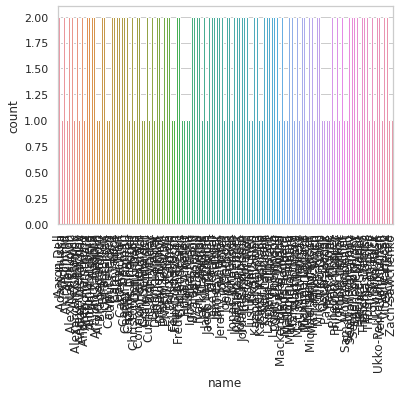

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")
sns.countplot(x = 'name', data = df1)
plt.rcParams["figure.figsize"] = (50,8)
plt.xticks(rotation=90, fontsize=12)
plt.show()

Find goalies that have played more than 5 games in one season:

In [22]:
df = merged_df
df = df[df.groupby('name')['games_played'].transform('max') > 5]
df.shape

(177, 35)

In [23]:
merged_df.shape

(217, 35)

Examine whether we have NaN values in caphit:

In [24]:
df[df['caphit'].isna()]

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
5,8471227,2020,Devan Dubnyk,COL,G,all,22,70942.0,48.89,63.0,...,158.0,42.0,17.43,18.25,13.21,24.0,26.0,13.0,298.0,NaN
9,8477480,2020,Eric Comrie,N.J,G,all,1,3600.0,3.08,3.0,...,10.0,3.0,1.14,1.23,0.71,2.0,0.0,1.0,9.0,NaN
12,8479973,2020,Stuart Skinner,EDM,G,all,1,3581.0,4.11,5.0,...,10.0,6.0,0.87,1.24,1.99,1.0,1.0,3.0,14.0,NaN
17,8476899,2020,Matt Murray,OTT,G,all,27,84251.0,63.09,79.0,...,203.0,56.0,20.28,24.48,18.32,29.0,25.0,25.0,331.0,NaN
21,8477361,2020,Calvin Petersen,L.A,G,all,35,119840.0,93.92,97.0,...,236.0,101.0,33.52,28.61,31.78,35.0,35.0,27.0,461.0,NaN
25,8478492,2020,Ilya Samsonov,WSH,G,all,19,65569.0,43.44,49.0,...,118.0,44.0,15.66,13.98,13.80,17.0,14.0,18.0,217.0,NaN
32,8478406,2020,Mackenzie Blackwood,N.J,G,all,35,125437.0,97.45,106.0,...,283.0,90.0,31.21,34.52,31.71,34.0,35.0,37.0,409.0,NaN
48,8475883,2020,Frederik Andersen,TOR,G,all,24,85216.0,65.25,70.0,...,223.0,63.0,18.72,26.89,19.65,12.0,35.0,23.0,289.0,NaN
52,8478916,2020,Joey Daccord,OTT,G,all,8,24202.0,21.02,22.0,...,70.0,20.0,6.22,8.48,6.32,5.0,11.0,6.0,94.0,NaN
67,8478435,2020,Dan Vladar,BOS,G,all,5,18004.0,15.06,17.0,...,39.0,15.0,4.17,4.84,6.05,2.0,5.0,10.0,49.0,NaN


We see that not all goalies have salary information for every season.

We can replace goalies NaN caphit values by inserting their average caphit value to those years caphit is missing.

In [25]:
# fill caphit nan values (had not played for that season) with players average caphit (https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group)
df['caphit'] = df['caphit'].fillna(df.groupby('name')['caphit'].transform('mean')) 
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
0,8470147,2020,Curtis McElhinney,T.B,G,all,12,43159.0,26.49,37.0,...,88.0,20.0,8.04,11.12,7.33,12.0,17.0,8.0,114.0,1300000.0
1,8473503,2020,James Reimer,CAR,G,all,22,79866.0,52.62,59.0,...,174.0,38.0,19.04,21.47,12.11,16.0,30.0,13.0,245.0,3400000.0
2,8477424,2020,Juuse Saros,NSH,G,all,36,123082.0,91.15,78.0,...,255.0,77.0,31.99,31.31,27.85,24.0,29.0,25.0,441.0,1500000.0
3,8476945,2020,Connor Hellebuyck,WPG,G,all,45,156169.0,131.25,112.0,...,435.0,132.0,38.44,52.86,39.96,28.0,50.0,34.0,598.0,6166666.0
5,8471227,2020,Devan Dubnyk,COL,G,all,22,70942.0,48.89,63.0,...,158.0,42.0,17.43,18.25,13.21,24.0,26.0,13.0,298.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,8470860,2021,Jaroslav Halak,VAN,G,all,17,47802.0,38.96,39.0,...,125.0,38.0,11.34,14.94,12.68,11.0,19.0,9.0,184.0,1500000.0
211,8478406,2021,Mackenzie Blackwood,NJD,G,all,25,83943.0,66.26,79.0,...,208.0,59.0,22.01,25.60,18.64,26.0,30.0,23.0,282.0,NaN
213,8480382,2021,Alexandar Georgiev,NYR,G,all,33,104766.0,78.16,85.0,...,223.0,82.0,26.51,27.42,24.23,33.0,25.0,27.0,408.0,2425000.0
214,8475831,2021,Philipp Grubauer,SEA,G,all,55,186685.0,130.26,164.0,...,388.0,119.0,43.26,47.19,39.81,57.0,62.0,45.0,672.0,5900000.0


In [26]:
df[df['caphit'].isna()]

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
5,8471227,2020,Devan Dubnyk,COL,G,all,22,70942.0,48.89,63.0,...,158.0,42.0,17.43,18.25,13.21,24.0,26.0,13.0,298.0,NaN
12,8479973,2020,Stuart Skinner,EDM,G,all,1,3581.0,4.11,5.0,...,10.0,6.0,0.87,1.24,1.99,1.0,1.0,3.0,14.0,NaN
17,8476899,2020,Matt Murray,OTT,G,all,27,84251.0,63.09,79.0,...,203.0,56.0,20.28,24.48,18.32,29.0,25.0,25.0,331.0,NaN
21,8477361,2020,Calvin Petersen,L.A,G,all,35,119840.0,93.92,97.0,...,236.0,101.0,33.52,28.61,31.78,35.0,35.0,27.0,461.0,NaN
32,8478406,2020,Mackenzie Blackwood,N.J,G,all,35,125437.0,97.45,106.0,...,283.0,90.0,31.21,34.52,31.71,34.0,35.0,37.0,409.0,NaN
52,8478916,2020,Joey Daccord,OTT,G,all,8,24202.0,21.02,22.0,...,70.0,20.0,6.22,8.48,6.32,5.0,11.0,6.0,94.0,NaN
67,8478435,2020,Dan Vladar,BOS,G,all,5,18004.0,15.06,17.0,...,39.0,15.0,4.17,4.84,6.05,2.0,5.0,10.0,49.0,NaN
73,8474636,2020,Michael Hutchinson,TOR,G,all,8,25312.0,15.58,17.0,...,56.0,8.0,6.60,6.14,2.84,7.0,8.0,2.0,88.0,NaN
111,8480925,2021,Pavel Francouz,COL,G,all,21,72009.0,52.94,51.0,...,168.0,53.0,15.88,20.61,16.45,17.0,17.0,17.0,257.0,NaN
115,8482076,2021,Nico Daws,NJD,G,all,25,76292.0,58.36,66.0,...,178.0,45.0,19.87,21.38,17.11,29.0,16.0,21.0,236.0,NaN


Caphit column has 23 NaN values. Let's examine what they are:

In [27]:
nan_values = df[df['caphit'].isna()]
nan_values['name'].unique

<bound method Series.unique of 5             Devan Dubnyk
12          Stuart Skinner
17             Matt Murray
21         Calvin Petersen
32     Mackenzie Blackwood
52            Joey Daccord
67              Dan Vladar
73      Michael Hutchinson
111         Pavel Francouz
115              Nico Daws
123     Michael Hutchinson
129           Akira Schmid
136             Dan Vladar
143       Sam Montembeault
180         Zach Sawchenko
188            Matt Murray
193          Erik Kallgren
194           Joey Daccord
205             J-F Berube
209         Stuart Skinner
211    Mackenzie Blackwood
Name: name, dtype: object>

Drop remaining rows with caphit as NaN:

In [28]:
df = df[df['caphit'].notna()]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 216
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   156 non-null    int64  
 1   season                     156 non-null    int64  
 2   name                       156 non-null    object 
 3   team                       156 non-null    object 
 4   position                   156 non-null    object 
 5   situation                  156 non-null    object 
 6   games_played               156 non-null    int64  
 7   icetime                    156 non-null    float64
 8   xGoals                     156 non-null    float64
 9   goals                      156 non-null    float64
 10  unblocked_shot_attempts    156 non-null    float64
 11  xRebounds                  156 non-null    float64
 12  rebounds                   156 non-null    float64
 13  xFreeze                    156 non-null    float64

Finally the dataframe looks ok.

### Data describing

In [30]:
df.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
0,8470147,2020,Curtis McElhinney,T.B,G,all,12,43159.0,26.49,37.0,...,88.0,20.0,8.04,11.12,7.33,12.0,17.0,8.0,114.0,1300000.0
1,8473503,2020,James Reimer,CAR,G,all,22,79866.0,52.62,59.0,...,174.0,38.0,19.04,21.47,12.11,16.0,30.0,13.0,245.0,3400000.0
2,8477424,2020,Juuse Saros,NSH,G,all,36,123082.0,91.15,78.0,...,255.0,77.0,31.99,31.31,27.85,24.0,29.0,25.0,441.0,1500000.0
3,8476945,2020,Connor Hellebuyck,WPG,G,all,45,156169.0,131.25,112.0,...,435.0,132.0,38.44,52.86,39.96,28.0,50.0,34.0,598.0,6166666.0
6,8479496,2020,David Rittich,TOR,G,all,19,57946.0,42.93,46.0,...,152.0,33.0,13.68,17.97,11.28,17.0,16.0,13.0,193.0,2750000.0


Start visually describe the salarydata. In order to understand the current situation in salaries, let's look only season 21-22.



In [31]:
df21 = df[df.season == 2021]
df21 = df21.sort_values(by=['name', 'season'], ignore_index=True)
df21.shape

(79, 35)

We're now looking the season 21-22 salary information of 73 goalies that have played in season at least 25 games since the start of season 2019-2022.

First we use boxplot from seaborn library to find:
- min and max caphits
- the blue box represents interquartile range (IQR) (25th to the 75th percentile)
- outliers, if any

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")

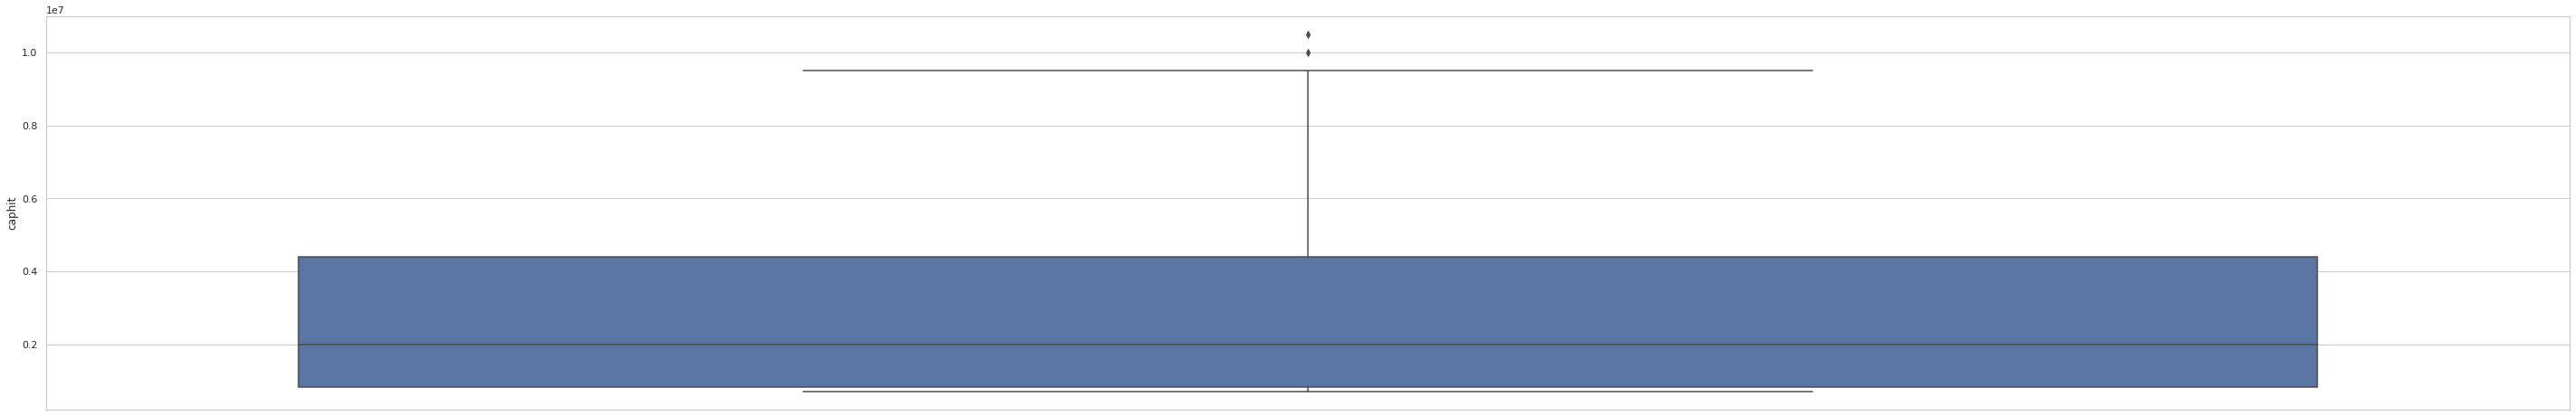

In [33]:
sns.boxplot(data = df21, y = 'caphit')


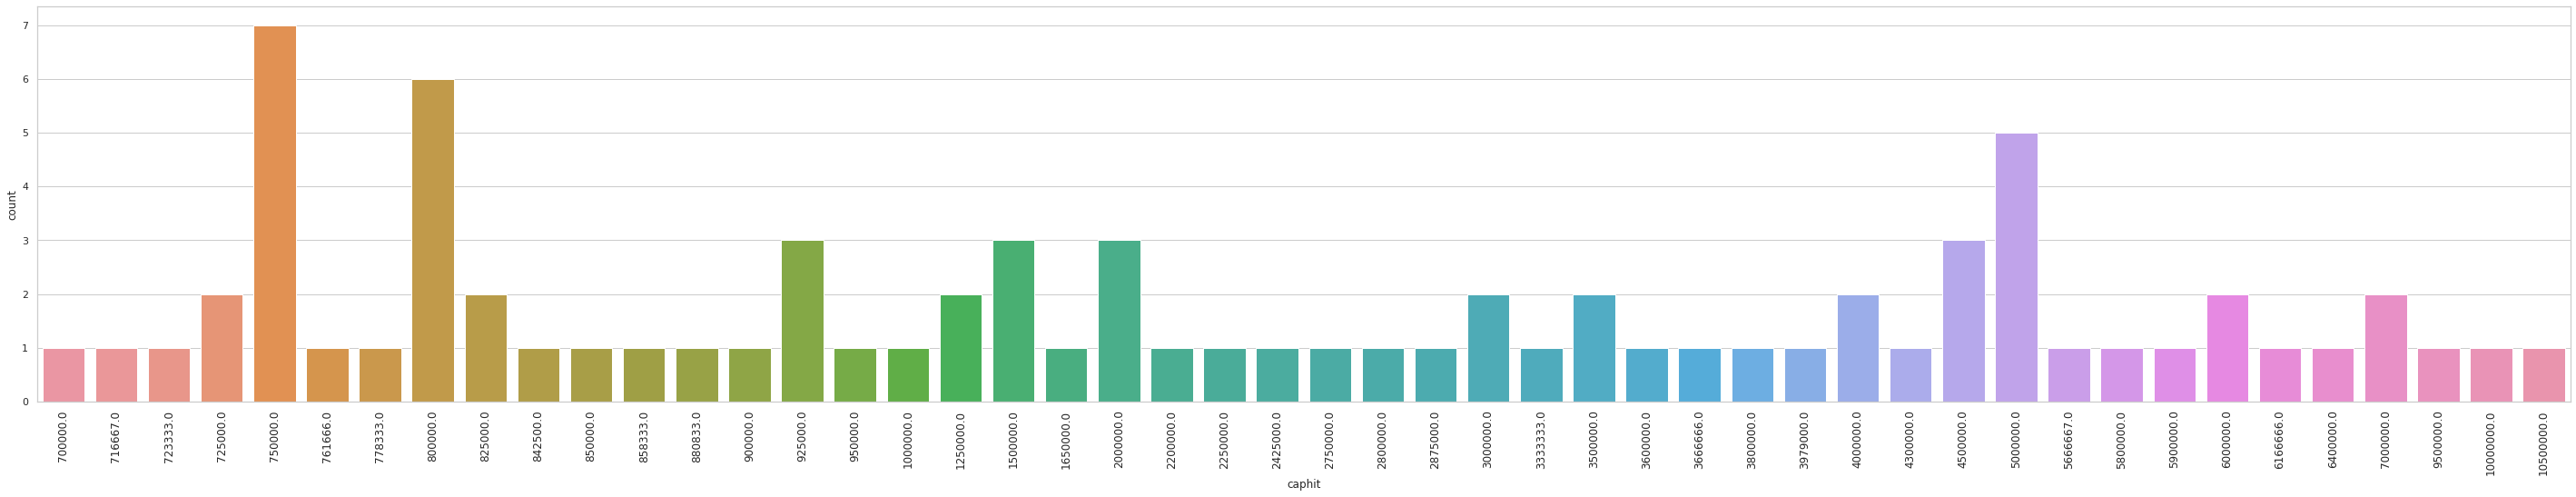

In [34]:
# For this visualisation, sort data by salary:
df21 = df21.sort_values(by=['caphit'], ignore_index=False)
sns.countplot(x = 'caphit', data = df21)
plt.rcParams["figure.figsize"] = (15,6)
plt.xticks(rotation=90, fontsize=12)
plt.show()

We see that most common salary is 750'000, which is the normal entry level contract.

Many goalies are on the standard entry level contract, they are not valued based on their performance. We will remove these:

In [35]:
# make a copy of the dataframe to filter newbies
df_veterans =df.loc[df['caphit'] != 750000]
#df_pg_old.drop(df_pg_old[df_pg_old['caphit'] == 750000].index, inplace = True)
#rslt_df = dataframe.loc[dataframe['Percentage'] != 95]

In [36]:
df21.nlargest(5, 'caphit')

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,caphit
16,8471679,2021,Carey Price,MTL,G,all,5,17850.0,13.19,18.0,...,45.0,9.0,4.44,5.60,3.14,7.0,5.0,6.0,87.0,10500000.0
69,8475683,2021,Sergei Bobrovsky,FLA,G,all,54,184930.0,160.39,137.0,...,449.0,186.0,41.99,55.69,62.72,38.0,52.0,47.0,612.0,10000000.0
5,8476883,2021,Andrei Vasilevskiy,TBL,G,all,63,225645.0,184.41,156.0,...,564.0,172.0,57.21,69.08,58.11,50.0,54.0,52.0,808.0,9500000.0
60,8470594,2021,Marc-Andre Fleury,MIN,G,all,56,197092.0,141.39,159.0,...,346.0,135.0,55.36,41.37,44.66,73.0,36.0,50.0,861.0,7000000.0
75,8471695,2021,Tuukka Rask,BOS,G,all,4,11781.0,9.56,14.0,...,26.0,12.0,1.80,3.40,4.36,3.0,5.0,6.0,40.0,7000000.0


-----

### Machine Learning

In this section we begin the process of finding what features in the statistic correlate with the salary.

In [37]:
df = df_veterans

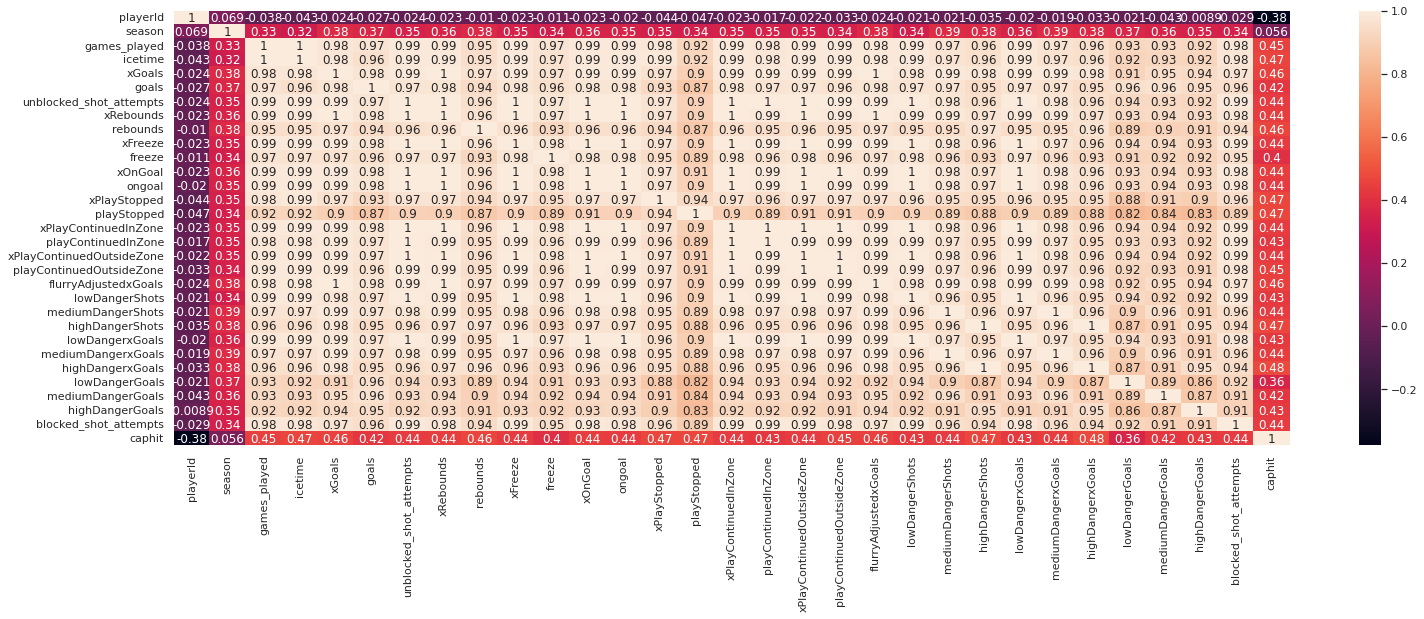

In [38]:
corrMatrix = df.corr()
sns.set(rc = {'figure.figsize':(25,8)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

The initial result is not very promising. Could not find any good features that would explain the salary. After closer examination of the feedback, we find that most of the features correlate highly with "games_played". Let's try to add new columns for most important features that resemble goalie performance and make it "per game" value. We select:
- Goals (allowed goals)
- rebounds
- low danger expected goals
- medium danger expected goals
- high danger expected goals

In [39]:
df_pg = df.drop(['playerId', 'season', 'goals', 'rebounds',  'lowDangerxGoals', 'mediumDangerxGoals', 'highDangerxGoals', 'position', 'icetime', 'name', 'situation', 'ongoal', 'playStopped', 'games_played', 'lowDangerShots', 'mediumDangerShots', 'highDangerShots', 'xGoals', 'unblocked_shot_attempts', 'xRebounds', 'xFreeze', 'freeze', 'xOnGoal', 'xPlayStopped', 'xPlayContinuedInZone', 'playContinuedInZone', 'xPlayContinuedOutsideZone', 'playContinuedOutsideZone', 'flurryAdjustedxGoals', 'blocked_shot_attempts', 'lowDangerGoals', 'mediumDangerGoals', 'highDangerGoals' ], axis = 1)

In [40]:
df_pg['goals_pg'] = df.goals / df.games_played
df_pg['rebounds_pg'] = df.rebounds / df.games_played
df_pg['lowDangerxGoals_pg'] = df.lowDangerxGoals / df.games_played
df_pg['mediumDangerxGoals_pg'] = df.mediumDangerxGoals / df.games_played
df_pg['highDangerxGoals_pg'] = df.highDangerxGoals / df.games_played
#df_pg = df_pg.drop(['goals', 'rebounds',  'lowDangerxGoals', 'mediumDangerxGoals', 'highDangerxGoals'], axis=1)

In [41]:
display(df_pg)

,team,caphit,goals_pg,rebounds_pg,lowDangerxGoals_pg,mediumDangerxGoals_pg,highDangerxGoals_pg
0,T.B,1300000.0,3.083333,1.250000,0.670000,0.926667,0.610833
1,CAR,3400000.0,2.681818,2.000000,0.865455,0.975909,0.550455
2,NSH,1500000.0,2.166667,2.277778,0.888611,0.869722,0.773611
3,WPG,6166666.0,2.488889,2.488889,0.854222,1.174667,0.888000
6,TOR,2750000.0,2.421053,1.789474,0.720000,0.945789,0.593684
...,...,...,...,...,...,...,...
206,VAN,800000.0,1.833333,3.500000,1.113333,1.341667,0.878333
210,VAN,1500000.0,2.294118,1.823529,0.667059,0.878824,0.745882
213,NYR,2425000.0,2.575758,2.303030,0.803333,0.830909,0.734242
214,SEA,5900000.0,2.981818,2.254545,0.786545,0.858000,0.723818


Let's see if we can visually see correlation between caphit and other features:

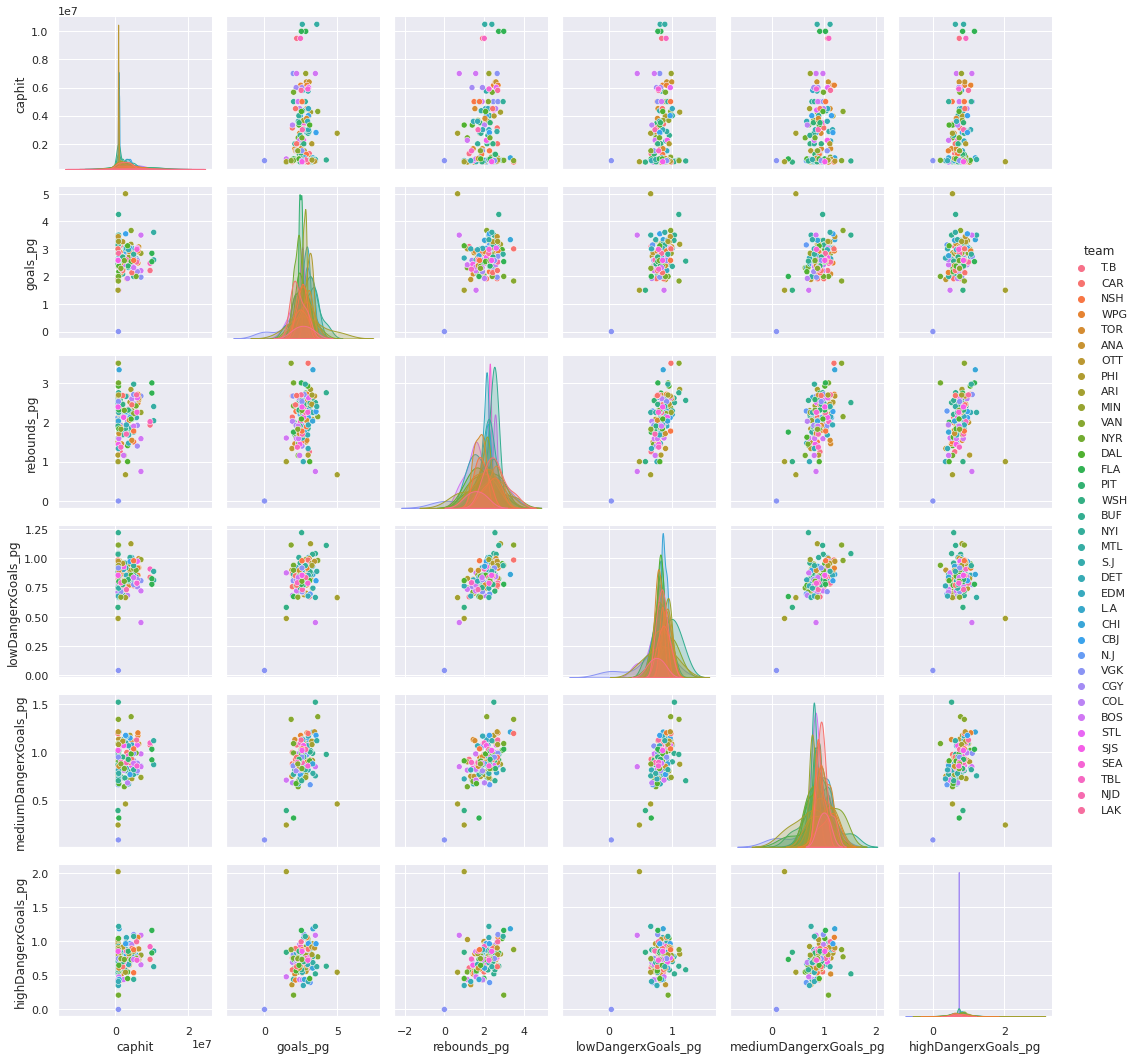

In [42]:
sns.pairplot(df_pg, hue="team")

Take a look at the feature distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a77675a90>,
      dtype=object)

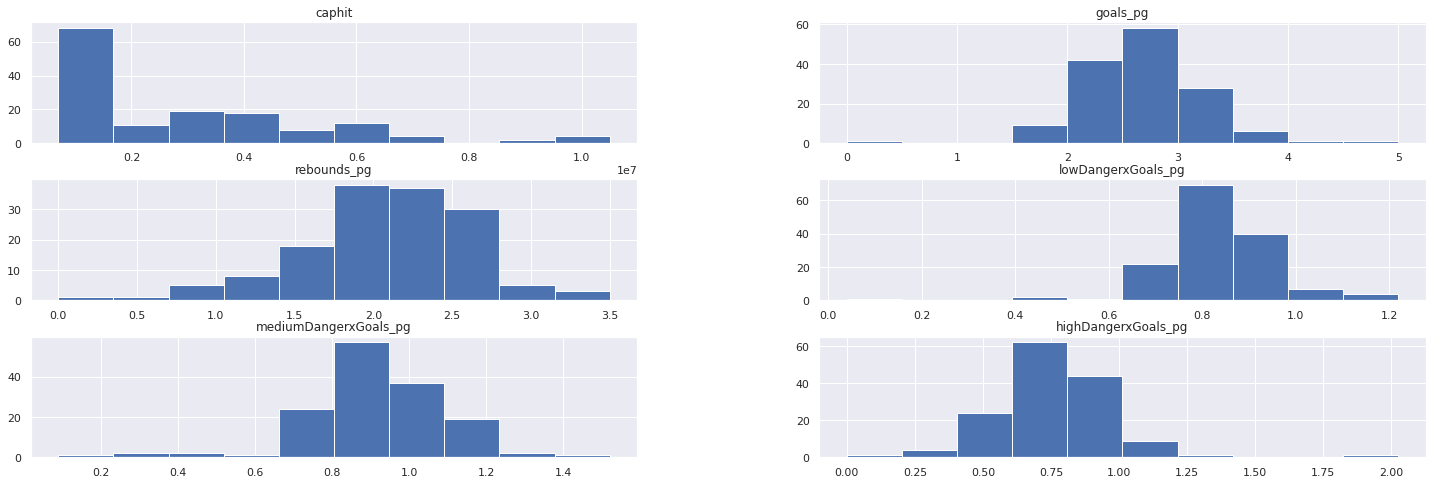

In [43]:
df_pg.hist()

And the heat matrix:

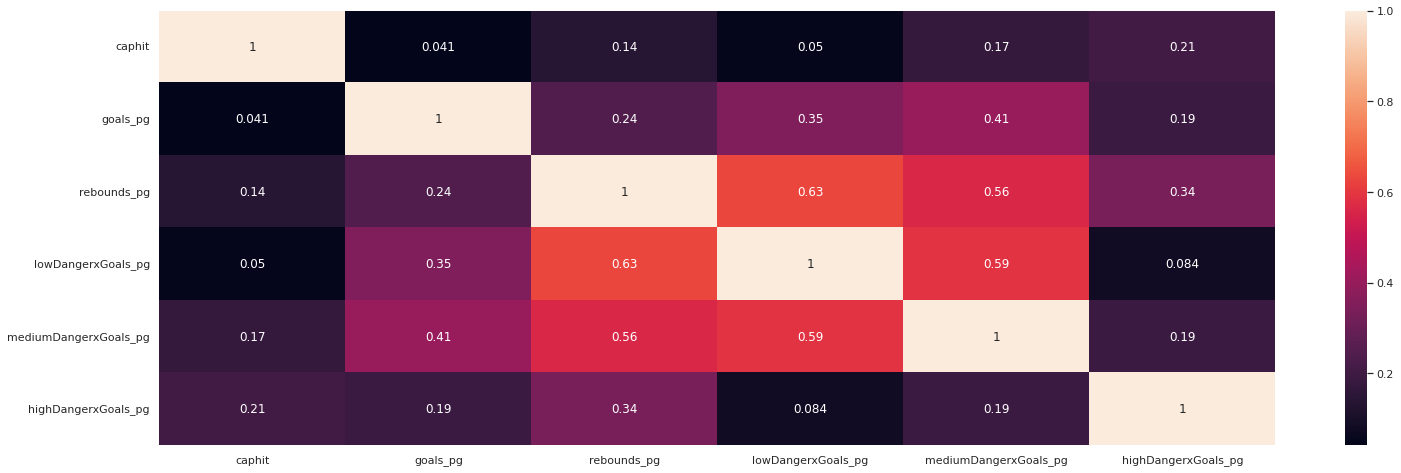

In [44]:
corrMatrix = df_pg.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

We see that *highDangerxGoals_pg*, *mediumDangerxGoals* and *rebounds* are the three highest correlation with the *caphit* (salary). This is logical, saving the dangerous shots and giving as few rebounds as possible means a valuable goalie. 

Try to normalize the data and see how that effects on the scatterplot. Let's examine the [effect on different scalers](https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/):

In [45]:
x = df_pg.drop(['team', 'caphit'], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 0 to 216
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   goals_pg               146 non-null    float64
 1   rebounds_pg            146 non-null    float64
 2   lowDangerxGoals_pg     146 non-null    float64
 3   mediumDangerxGoals_pg  146 non-null    float64
 4   highDangerxGoals_pg    146 non-null    float64
dtypes: float64(5)
memory usage: 6.8 KB


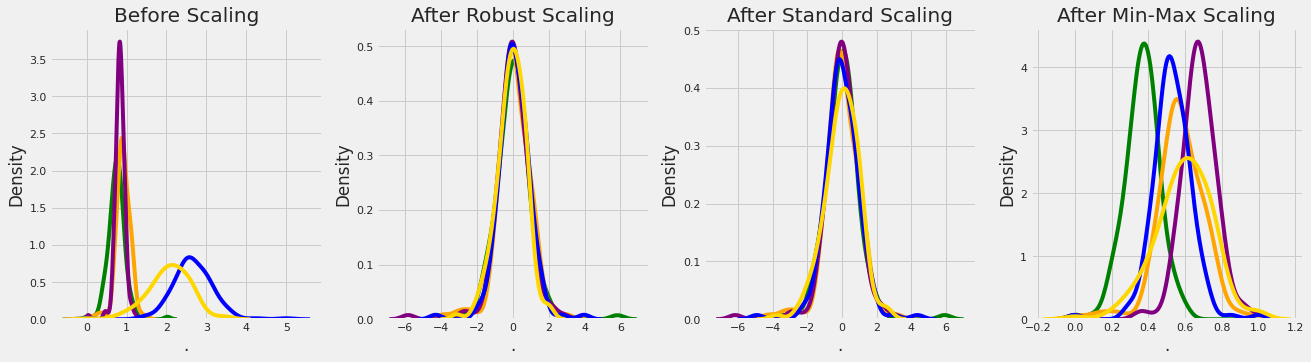

In [80]:
# Importing libraries

from sklearn import preprocessing

scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['goals_pg', 'rebounds_pg', 'lowDangerxGoals_pg', 'mediumDangerxGoals_pg' , 'highDangerxGoals_pg'])
 
scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['goals_pg', 'rebounds_pg', 'lowDangerxGoals_pg', 'mediumDangerxGoals_pg' , 'highDangerxGoals_pg'])
 
scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['goals_pg', 'rebounds_pg', 'lowDangerxGoals_pg', 'mediumDangerxGoals_pg' , 'highDangerxGoals_pg'])
 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_xlabel('.')
ax2.set_xlabel('.')
ax3.set_xlabel('.')
ax4.set_xlabel('.')

ax1.set_title('Before Scaling')
sns.kdeplot(x['highDangerxGoals_pg'], ax = ax1, color ='green')
sns.kdeplot(x['mediumDangerxGoals_pg'],ax = ax1, color ='orange')
sns.kdeplot(x['lowDangerxGoals_pg'], ax = ax1, color ='purple')
sns.kdeplot(x['goals_pg'], ax = ax1, color ='blue')
sns.kdeplot(x['rebounds_pg'], ax = ax1, color ='gold')

ax2.set_title('After Robust Scaling')
sns.kdeplot(robust_df['highDangerxGoals_pg'], ax = ax2, color ='green')
sns.kdeplot(robust_df['mediumDangerxGoals_pg'], ax = ax2, color ='orange')
sns.kdeplot(robust_df['lowDangerxGoals_pg'], ax = ax2, color ='purple')
sns.kdeplot(robust_df['goals_pg'], ax = ax2, color ='blue')
sns.kdeplot(robust_df['rebounds_pg'], ax = ax2, color ='gold')

ax3.set_title('After Standard Scaling')
sns.kdeplot(standard_df['highDangerxGoals_pg'], ax = ax3, color ='green')
sns.kdeplot(standard_df['mediumDangerxGoals_pg'], ax = ax3, color ='orange')
sns.kdeplot(standard_df['lowDangerxGoals_pg'], ax = ax3, color ='purple')
sns.kdeplot(standard_df['goals_pg'], ax = ax3, color ='blue')
sns.kdeplot(standard_df['rebounds_pg'], ax = ax3, color ='gold')

ax4.set_title('After Min-Max Scaling')
sns.kdeplot(minmax_df['highDangerxGoals_pg'], ax = ax4, color ='green')
sns.kdeplot(minmax_df['mediumDangerxGoals_pg'], ax = ax4, color ='orange')
sns.kdeplot(minmax_df['lowDangerxGoals_pg'], ax = ax4, color ='purple')
sns.kdeplot(minmax_df['goals_pg'], ax = ax4, color ='blue')
sns.kdeplot(minmax_df['rebounds_pg'], ax = ax4, color ='gold')
plt.show()

We will select robust scaler!

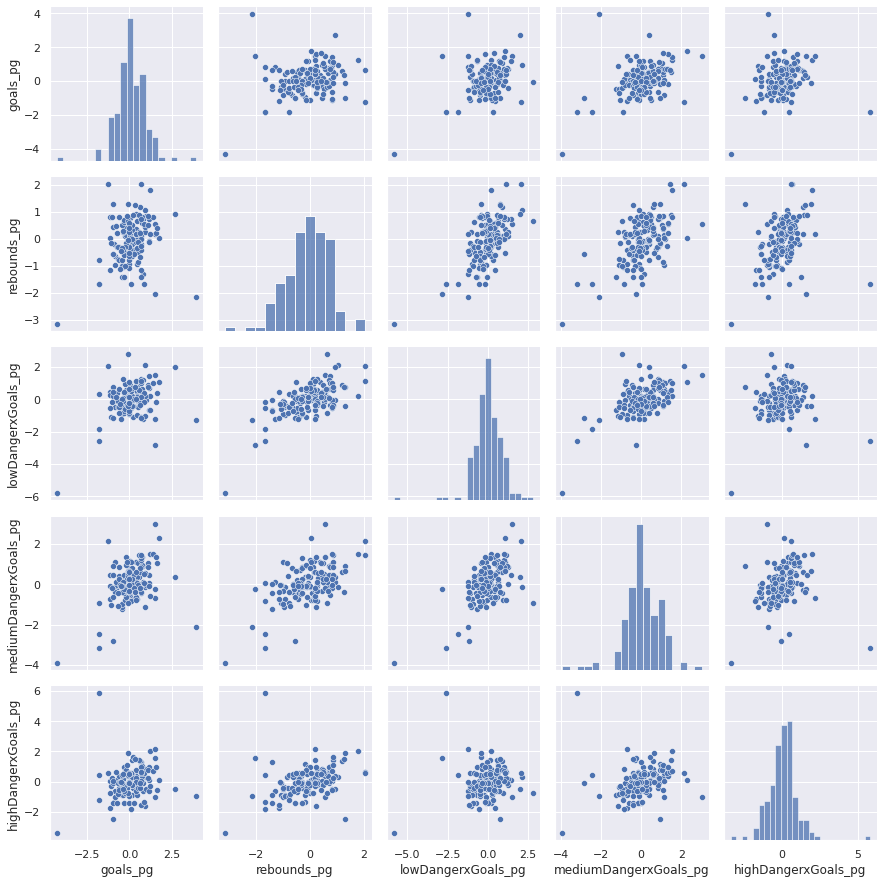

In [47]:
sns.pairplot(robust_df)

Revisit the heatmap and see if there is any difference with scaled features:

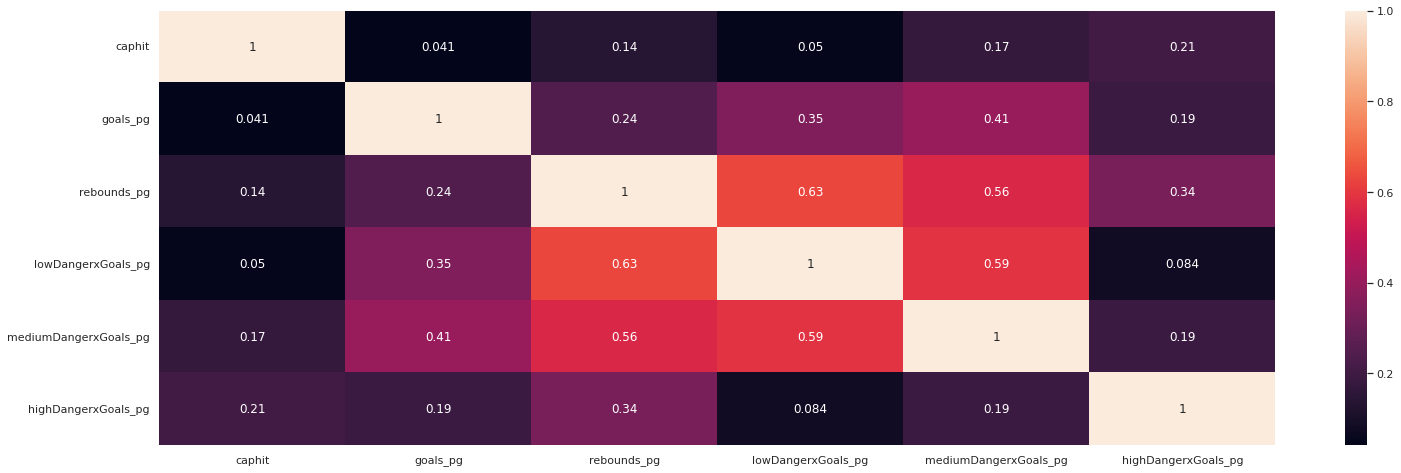

In [316]:
corrMatrix = robust_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Let's try two different models and see how they perform: (https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/) 

In [319]:
# separate df to target and input:
x = robust_df.drop('caphit',axis=1)
y = robust_df['caphit']

In [320]:
# split the data in training and test
from sklearn.model_selection import train_test_split
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42) 

In [321]:
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.554 (0.087)
